<a href="https://colab.research.google.com/github/abhishek-3740/machine_learningRepo/blob/main/DCGAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

class Discriminator(nn.Module):
    def __init__(self, channel_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(   # N * channel_img * 64 * 64
            nn.Conv2d(channel_img, features_d, kernel_size=4, stride=2, padding=1),  # 32, 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),  # 16,16
            self._block(features_d*2, features_d*4, 4, 2, 1), # 8,8
            self._block(features_d*4, features_d*8, 4, 2, 1), # 4,4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=1, padding=0),  # 1,1
            nn.Sigmoid(),
        )

    def _block(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, channel_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # N * z_dim * 1 * 1
            self._block(z_dim, features_g*16, 4, 1, 0), # N * f_g * 4 * 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8 * 8
            self._block(features_g*8, features_g*4, 4, 2, 1),  # 16 * 16
            self._block(features_g*4, features_g*2, 4, 2, 1),  # 32 * 32
            nn.ConvTranspose2d(features_g*2, channel_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)

    # Test generator as well
    noise = torch.randn((N, z_dim, 1, 1))
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    assert gen(noise).shape == (N, in_channels, H, W)
    print("Tests passed!")


# Run test
test()

# Training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

# Data preprocessing
transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
    ),
])

# Dataset and dataloader
# If you train on MNIST, remember to set channels_img to 1
dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms, download=True
)

# comment mnist above and uncomment below if train on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize models
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# For monitoring training
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

# Training
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} "
                f"Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Tests passed!


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.22MB/s]


Epoch [0/5] Batch 0/469 Loss D: 0.7025, loss G: 0.7738
Epoch [0/5] Batch 100/469 Loss D: 0.0146, loss G: 4.1241
Epoch [0/5] Batch 200/469 Loss D: 1.3938, loss G: 0.1290
Epoch [0/5] Batch 300/469 Loss D: 0.4794, loss G: 1.2244
Epoch [0/5] Batch 400/469 Loss D: 0.7261, loss G: 0.8936
Epoch [1/5] Batch 0/469 Loss D: 0.6030, loss G: 1.1488
Epoch [1/5] Batch 100/469 Loss D: 0.6240, loss G: 0.6420
Epoch [1/5] Batch 200/469 Loss D: 0.6305, loss G: 0.8767
Epoch [1/5] Batch 300/469 Loss D: 0.7010, loss G: 0.7962
Epoch [1/5] Batch 400/469 Loss D: 0.6435, loss G: 0.8104
Epoch [2/5] Batch 0/469 Loss D: 0.6395, loss G: 0.8179
Epoch [2/5] Batch 100/469 Loss D: 0.5992, loss G: 0.9723
Epoch [2/5] Batch 200/469 Loss D: 0.5877, loss G: 0.8021
Epoch [2/5] Batch 300/469 Loss D: 0.5900, loss G: 0.8547
Epoch [2/5] Batch 400/469 Loss D: 0.7135, loss G: 0.7482
Epoch [3/5] Batch 0/469 Loss D: 0.5458, loss G: 0.9801
Epoch [3/5] Batch 100/469 Loss D: 0.5654, loss G: 0.6455
Epoch [3/5] Batch 200/469 Loss D: 0.597

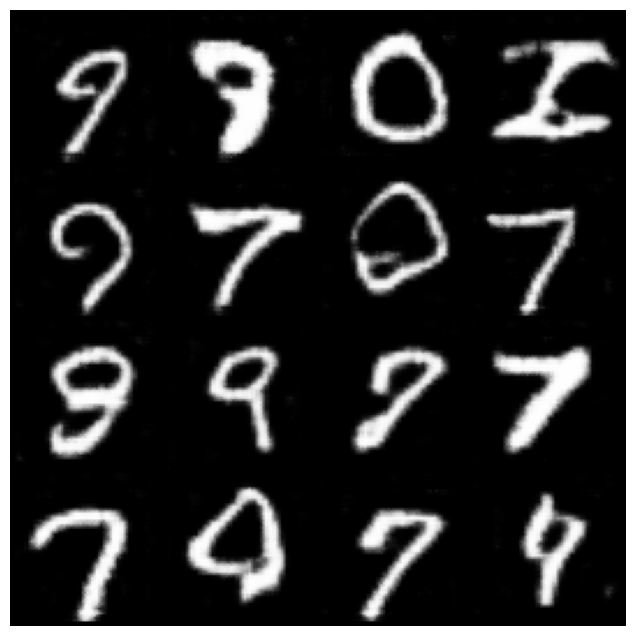

In [5]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_images(generator, device):
    """Show generated images"""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(16, 100, 1, 1).to(device)
        fake = generator(noise)
        grid = make_grid(fake, nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()
    generator.train()

# Usage:
show_images(gen, device)